In [1]:
#Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.optimize import linprog


np.random.seed(42)

# Parameters
num_samples = 1000
products = ['Tomato', 'Potato', 'Rice', 'Soybean', 'Onion']
regions = ['North', 'South', 'East', 'West']
transport_modes = ['Truck', 'Train', 'Ship']

# Generate synthetic data
data = {
    'Product': np.random.choice(products, num_samples),
    'Region': np.random.choice(regions, num_samples),
    'Distance_km': np.random.uniform(10, 50, num_samples),  # Distance in kilometers
    'Weight_kg': np.random.uniform(10, 200, num_samples),  # Weight in kilograms
    'Harvest_Time_days': np.random.randint(1, 30, num_samples),  # Time taken to harvest
    'Storage_Time_days': np.random.randint(1, 15, num_samples),  # Time spent in storage
    'Transport_Mode': np.random.choice(transport_modes, num_samples),  # Mode of transport
    'Market_Demand': np.random.randint(10, 50, num_samples),  # Demand at market
    'Supply_Chain_Risk': np.random.uniform(0.1, 1.0, num_samples),  # Risk factor in supply chain
    'Price_per_kg': np.random.uniform(0.5, 5.0, num_samples)  # Price per kg at market
}

# Create DataFrame
df = pd.DataFrame(data)

# cost function: Cost = Distance * Weight * Rate (where Rate is a constant)
cost_rate = 0.5  # Cost rate per kg per km
df['Transportation_Cost'] = df['Distance_km'] * df['Weight_kg'] * cost_rate

# Calculate total time including harvest and storage time for optimization objective
df['Total_Time_days'] = df['Harvest_Time_days'] + df['Storage_Time_days'] + (df['Distance_km'] / 50)  # Assuming average speed of 50 km/day

print("Synthetic Data Sample:")
print(df.head())


Synthetic Data Sample:
   Product Region  Distance_km   Weight_kg  Harvest_Time_days  \
0  Soybean   West    16.699303   51.623074                 25   
1    Onion   West    14.182714   16.977059                 17   
2     Rice   West    35.457210   30.524893                 13   
3    Onion   West    38.259029   74.383523                 18   
4    Onion   West    11.263446  162.491279                  2   

   Storage_Time_days Transport_Mode  Market_Demand  Supply_Chain_Risk  \
0                  7          Train             46           0.517543   
1                 11          Truck             43           0.321237   
2                  2          Truck             29           0.923358   
3                  1          Truck             44           0.401866   
4                  3           Ship             27           0.957038   

   Price_per_kg  Transportation_Cost  Total_Time_days  
0      2.712821           431.034682        32.333986  
1      4.533063           120.39038

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product              1000 non-null   object 
 1   Region               1000 non-null   object 
 2   Distance_km          1000 non-null   float64
 3   Weight_kg            1000 non-null   float64
 4   Harvest_Time_days    1000 non-null   int32  
 5   Storage_Time_days    1000 non-null   int32  
 6   Transport_Mode       1000 non-null   object 
 7   Market_Demand        1000 non-null   int32  
 8   Supply_Chain_Risk    1000 non-null   float64
 9   Price_per_kg         1000 non-null   float64
 10  Transportation_Cost  1000 non-null   float64
 11  Total_Time_days      1000 non-null   float64
dtypes: float64(6), int32(3), object(3)
memory usage: 82.2+ KB

Statistical Summary:
       Distance_km    Weight_kg  Harvest_Time_days  Storage_Time_days  \
count  1000.000000

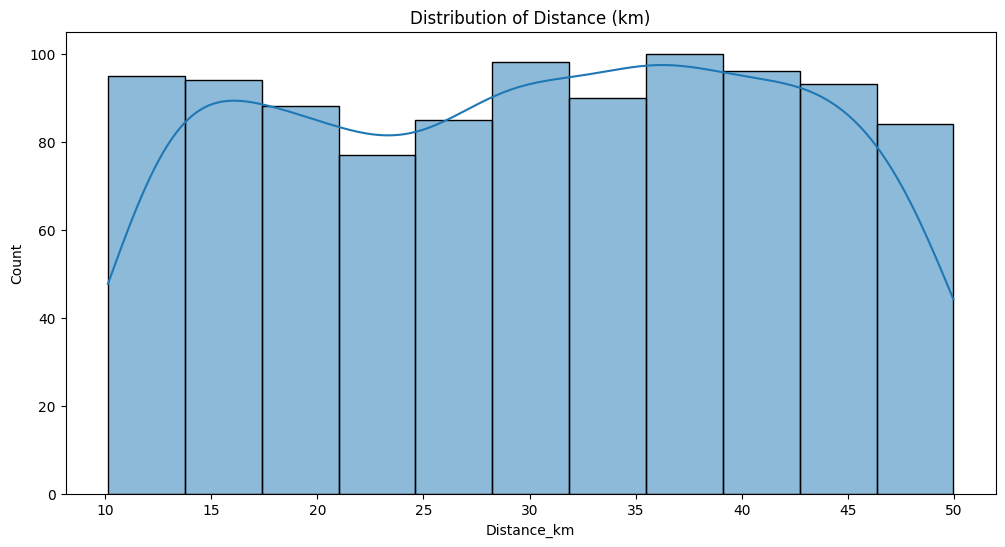

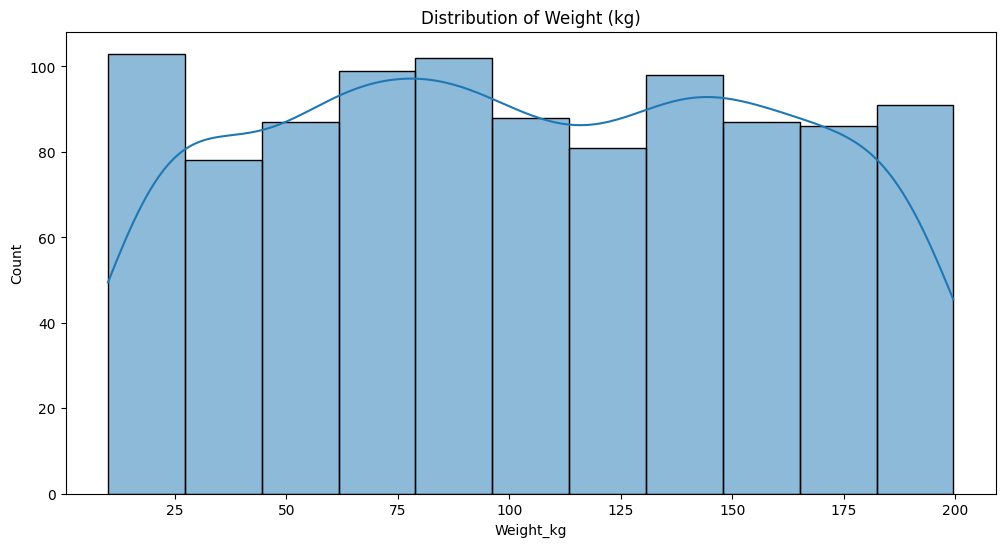

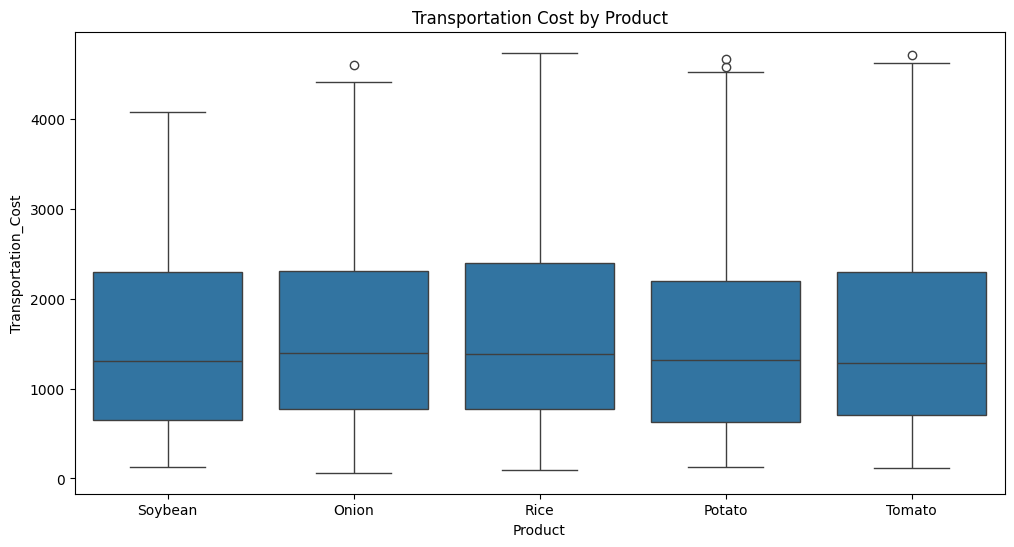

In [2]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information
print("Data Information:")
df.info()

print("\nStatistical Summary:")
print(df.describe())

# Check for class distribution
print("\nProduct Distribution:")
print(df['Product'].value_counts())

print("\nRegion Distribution:")
print(df['Region'].value_counts())

# Visualizations
plt.figure(figsize=(12, 6))
sns.histplot(df['Distance_km'], kde=True)
plt.title('Distribution of Distance (km)')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['Weight_kg'], kde=True)
plt.title('Distribution of Weight (kg)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Product', y='Transportation_Cost', data=df)
plt.title('Transportation Cost by Product')
plt.show()


In [3]:
# Data Cleaning

# Check for missing values
print("Missing Values by Column:")
print(df.isnull().sum())

# Remove any duplicates
df.drop_duplicates(inplace=True)

# Reset index after removing duplicates
df.reset_index(drop=True, inplace=True)

# Display cleaned data sample
print("\nCleaned Data Sample:")
print(df.head())


Missing Values by Column:
Product                0
Region                 0
Distance_km            0
Weight_kg              0
Harvest_Time_days      0
Storage_Time_days      0
Transport_Mode         0
Market_Demand          0
Supply_Chain_Risk      0
Price_per_kg           0
Transportation_Cost    0
Total_Time_days        0
dtype: int64

Cleaned Data Sample:
   Product Region  Distance_km   Weight_kg  Harvest_Time_days  \
0  Soybean   West    16.699303   51.623074                 25   
1    Onion   West    14.182714   16.977059                 17   
2     Rice   West    35.457210   30.524893                 13   
3    Onion   West    38.259029   74.383523                 18   
4    Onion   West    11.263446  162.491279                  2   

   Storage_Time_days Transport_Mode  Market_Demand  Supply_Chain_Risk  \
0                  7          Train             46           0.517543   
1                 11          Truck             43           0.321237   
2                  2         

In [4]:
# Prepare features and target variable (using Total_Time_days as target)
X = df[['Distance_km', 'Weight_kg', 'Harvest_Time_days', 'Storage_Time_days', 'Market_Demand', 'Supply_Chain_Risk', 'Price_per_kg']]
y = df['Total_Time_days']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model (using Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set and evaluate performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'\nMean Squared Error: {mse}')



Mean Squared Error: 0.39971474652065553


In [5]:
# Optimization Technique using MIQP (using linprog as placeholder)

# Coefficients for the objective function (minimize total transportation time)
c = model.predict(X.values)  # Predicted total time for all samples

# Constraints: e.g., total weight should not exceed a limit (e.g., 50,000 kg)
A_eq = [df['Weight_kg'].values]
b_eq = [50000]  # Total weight limit

# Bounds for each variable (either take or not take each product)
x_bounds = [(0, 1) for _ in range(num_samples)]

# Solve the mixed-integer quadratic programming problem using linprog as a placeholder for MIQP
result = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds)

if result.success:
    print("\nOptimal solution found:")
    print(result.x)  # Indicates which products to transport (1 means include)
else:
    print("No optimal solution found.")



Optimal solution found:
[0.         0.         0.         0.         1.         1.
 0.         0.         1.         0.         0.         0.
 0.         0.         1.         0.         1.         0.
 1.         0.         0.         0.         1.         0.
 0.         0.         1.         0.         1.         0.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         1.
 1.         0.         1.         0.         0.         0.
 1.         1.         0.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         1.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         0.         0.
 0.         1.         0.         1.         0.         0.
 1.         0.         1.      

c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
